# Total population (actual and forecasted) per district, and optionally compute the growth.

In [2]:
import pandas as pd

# Load the forecast dataset with full path
csv_path = r"KTZH_area_forecast.csv"
forecast_df = pd.read_csv(csv_path)

print(f"✅ Dataset loaded: {len(forecast_df)} rows")
print("Available years:", sorted(forecast_df['year'].unique()))
print("Data types:", forecast_df['data type'].unique())

# Filter the dataset to keep only specific years
# 2023: Latest actual data (historical)
# 2030: Short-term forecast
# 2045: Long-term forecast
filtered_df = forecast_df[forecast_df['year'].isin([2023, 2050])]

print(f"📊 Filtered dataset: {len(filtered_df)} rows for years 2023, 2050")

# Group by district, data type, and year, then sum the population
population_summary = filtered_df.groupby(['district', 'data type', 'year'])['number'].sum().reset_index()

# Pivot to have years as columns
population_pivot = population_summary.pivot_table(
    index=['district', 'data type'], 
    columns='year', 
    values='number', 
    fill_value=0
).reset_index()

# Flatten column names
population_pivot.columns.name = None
population_pivot.columns = ['district', 'data_type'] + [f'pop_{year}' for year in [2023, 2050]]

print("📈 Population data structure:")
print(population_pivot.head())

# Filter for actual vs forecast data types
actual_data = population_pivot[population_pivot['data_type'] == 'Pop_Actual'].copy()
forecast_data = population_pivot[population_pivot['data_type'] == 'Pop_Forecast'].copy()

# Merge actual and forecast data
if len(actual_data) > 0 and len(forecast_data) > 0:
    # Use 2023 as baseline (actual), 2030 and 2045 as forecasts
    population_analysis = actual_data[['district', 'pop_2023']].merge(
        forecast_data[['district', 'pop_2050']], 
        on='district', 
        how='outer'
    ).fillna(0)
    
    
    population_analysis['growth_rate_2050'] = (
        (population_analysis['pop_2050'] - population_analysis['pop_2023']) /
        population_analysis['pop_2023']
    ) * 100
    
else:
    # Alternative approach: use the filtered data directly by year
    population_2023 = filtered_df[filtered_df['year'] == 2023].groupby('district')['number'].sum()
    population_2050 = filtered_df[filtered_df['year'] == 2050].groupby('district')['number'].sum()
    
    # Create analysis DataFrame
    population_analysis = pd.DataFrame({
        'district': population_2023.index,
        'pop_2023': population_2023.values,
        'pop_2050': population_2050.reindex(population_2023.index, fill_value=0).values
    })
    
    # Calculate growth rates  
    population_analysis['growth_rate_2050'] = (
        (population_analysis['pop_2050'] - population_analysis['pop_2023']) /
        population_analysis['pop_2023']
    ) * 100

print("\n📊 Population Analysis by District:")
print("="*80)

# Display formatted results
for idx, row in population_analysis.iterrows():
    print(f"🏘️  {row['district']}")
    print(f"   2023 (Actual): {row['pop_2023']:,.0f}")
    print(f"   2050 (Forecast): {row['pop_2050']:,.0f} ({row['growth_rate_2050']:+.1f}%)")
    print("-" * 50)

# Summary statistics
print(f"\n📈 Summary:")
print(f"Average growth 2023-2050: {population_analysis['growth_rate_2050'].mean():.1f}%")

# Add the km2 area for each district
area = pd.read_csv('Area_size.csv')
population_analysis = pd.merge(population_analysis, area, on='district', how='left')

# Calculate the density of the district and absolute growth population
population_analysis['growth_abs'] = population_analysis['pop_2050']- population_analysis['pop_2023']
population_analysis['dencity_growth'] = population_analysis['growth_abs']/population_analysis['Area (Area km²)']
population_analysis = population_analysis.sort_values(by='dencity_growth', ascending=False)

# Display styled DataFrame
styled_df = population_analysis.style.format({
    'pop_2023': '{:,.0f}',
    'pop_2050': '{:,.0f}',
    'growth_rate_2050': '{:+.2f}%',
    'Area (Area km²)':'{:,.1f}',
    'growth_abs':'{:,.1f}',
    'dencity_growth':'{:,.2f}'
})

display(styled_df)

✅ Dataset loaded: 19680 rows
Available years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]
Data types: ['Pop_Actual' 'Pop_Forecast']
📊 Filtered dataset: 960 rows for years 2023, 2050
📈 Population data structure:
      district     data_type  pop_2023   pop_2050
0    Affoltern    Pop_Actual   57558.0      0.000
1    Affoltern  Pop_Forecast       0.0  70496.544
2  Andelfingen    Pop_Actual   32671.0      0.000
3  Andelfingen  Pop_Forecast       0.0  39488.064
4       Bülach    Pop_Actual  163636.0      0.000

📊 Population Analysis by District:
🏘️  Affoltern
   2023 (Actual): 57,558
   2050 (Forecast): 70,497 (+22.5%)
--------------------------------------------------
🏘️  Andelfingen
   2023 (Actual): 32,671
   2050 (Forecast): 39,488 (+20.9%)
-----------------------------------------------

,district,pop_2023,pop_2050,growth_rate_2050,Area (Area km²),growth_abs,dencity_growth
11,Zürich,"432,552","539,636",+24.76%,91.9,"107,083.8","1,165.22"
4,Dietikon,"97,401","128,862",+32.30%,60.1,"31,460.8",523.47
9,Uster,"139,677","182,506",+30.66%,120.5,"42,828.9",355.43
6,Horgen,"130,994","161,133",+23.01%,127.9,"30,138.5",235.64
2,Bülach,"163,636","201,594",+23.20%,185.3,"37,957.5",204.84
10,Winterthur,"179,830","228,342",+26.98%,251.1,"48,512.4",193.20
7,Meilen,"108,615","129,316",+19.06%,116.8,"20,700.8",177.23
3,Dielsdorf,"94,931","115,233",+21.39%,152.6,"20,301.6",133.04
5,Hinwil,"100,651","122,352",+21.56%,179.5,"21,700.8",120.90
0,Affoltern,"57,558","70,497",+22.48%,113.0,"12,938.5",114.50


# SPAR Presence vs. Total Supermarket

In [3]:
import pandas as pd

# Load the supermarket dataset
supermarkets_df = pd.read_csv('all_supermarkets_with_size_and_rating.csv')

# Count total supermarkets per district
total_supermarkets = supermarkets_df.groupby('district').size().reset_index(name='total_supermarkets')

# Count SPAR supermarkets per district
spar_supermarkets = supermarkets_df[supermarkets_df['name'].str.contains('spar', case=False)]
spar_counts = spar_supermarkets.groupby('district').size().reset_index(name='spar_supermarkets')

# Merge both counts together
supermarket_coverage = pd.merge(total_supermarkets, spar_counts, on='district', how='left')

# Fill missing SPAR counts with 0
supermarket_coverage['spar_supermarkets'] = supermarket_coverage['spar_supermarkets'].fillna(0).astype(int)

# Preview result
supermarket_coverage.sort_values(by='spar_supermarkets', ascending=True).head(12)


,district,total_supermarkets,spar_supermarkets
1,Andelfingen,7,1
5,Hinwil,32,1
7,Meilen,32,1
8,Pfäffikon,23,1
0,Affoltern,13,2
2,Bülach,63,3
4,Dietikon,37,3
9,Uster,47,4
6,Horgen,46,6
3,Dielsdorf,32,7


# Identify High-Opportunity Districts for SPAR Expansion

In [4]:
# Merge population growth data with supermarket counts
opportunity_df = pd.merge(population_analysis, supermarket_coverage, on='district', how='left')

# Calculate SPAR coverage rate and people per SPAR (use NaN where SPAR count is zero)
opportunity_df['spar_coverage_rate'] = opportunity_df['spar_supermarkets'] / opportunity_df['total_supermarkets']
opportunity_df['people_per_spar'] = opportunity_df['pop_2050'] / opportunity_df['spar_supermarkets'].replace(0, pd.NA)
opportunity_df['people_per_supermarket']=opportunity_df['pop_2050'] / opportunity_df['total_supermarkets']

# Rank districts by highest growth and lowest SPAR coverage
opportunity_df['growth_rate'] = opportunity_df['growth_rate_2050']  # use 2045 growth for ranking
best_opportunities = opportunity_df.sort_values(by=['dencity_growth', 'people_per_supermarket'], ascending=[False, True])

# Display top 5 opportunities
best_opportunities[['district', 'pop_2050', 'dencity_growth', 'total_supermarkets',
                    'spar_supermarkets', 'spar_coverage_rate', 'people_per_spar']].head(5)

# Format large numbers with commas and round decimals
best_opportunities[['district', 'pop_2050', 'dencity_growth', 'total_supermarkets',
                    'spar_supermarkets', 'spar_coverage_rate', 'people_per_spar', 'people_per_supermarket']
].style.format({
    'pop_2050': '{:,.0f}',
    'dencity_growth': '{:.2f}',
    'spar_coverage_rate': '{:.2%}',
    'people_per_spar': '{:,.0f}',
    'people_per_supermarket': '{:,.0f}'
})


,district,pop_2050,dencity_growth,total_supermarkets,spar_supermarkets,spar_coverage_rate,people_per_spar,people_per_supermarket
0,Zürich,"539,636",1165.22,181,11,6.08%,"49,058","2,981"
1,Dietikon,"128,862",523.47,37,3,8.11%,"42,954","3,483"
2,Uster,"182,506",355.43,47,4,8.51%,"45,626","3,883"
3,Horgen,"161,133",235.64,46,6,13.04%,"26,855","3,503"
4,Bülach,"201,594",204.84,63,3,4.76%,"67,198","3,200"
5,Winterthur,"228,342",193.20,71,7,9.86%,"32,620","3,216"
6,Meilen,"129,316",177.23,32,1,3.12%,"129,316","4,041"
7,Dielsdorf,"115,233",133.04,32,7,21.88%,"16,462","3,601"
8,Hinwil,"122,352",120.90,32,1,3.12%,"122,352","3,823"
9,Affoltern,"70,497",114.50,13,2,15.38%,"35,248","5,423"


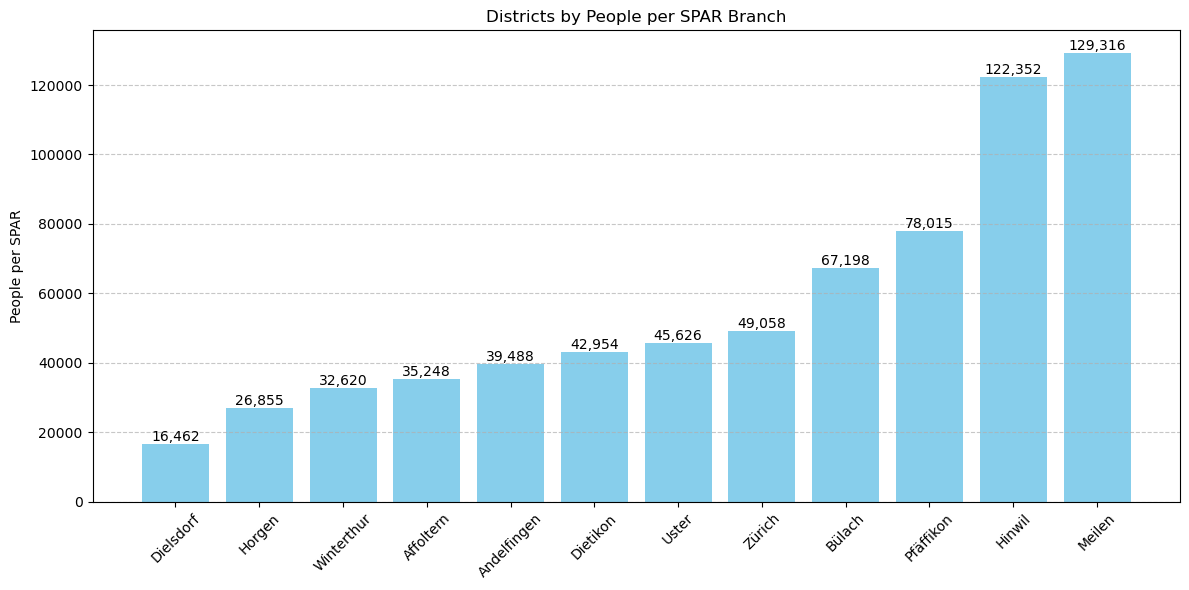

In [5]:
import matplotlib.pyplot as plt

# Sort by people_per_spar and take top 10
plot_df = best_opportunities.sort_values('people_per_spar', ascending=True).head(12)

plt.figure(figsize=(12, 6))
bars = plt.bar(plot_df['district'], plot_df['people_per_spar'], color='skyblue')

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', ha='center', va='bottom')

plt.title('Districts by People per SPAR Branch')
plt.ylabel('People per SPAR')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


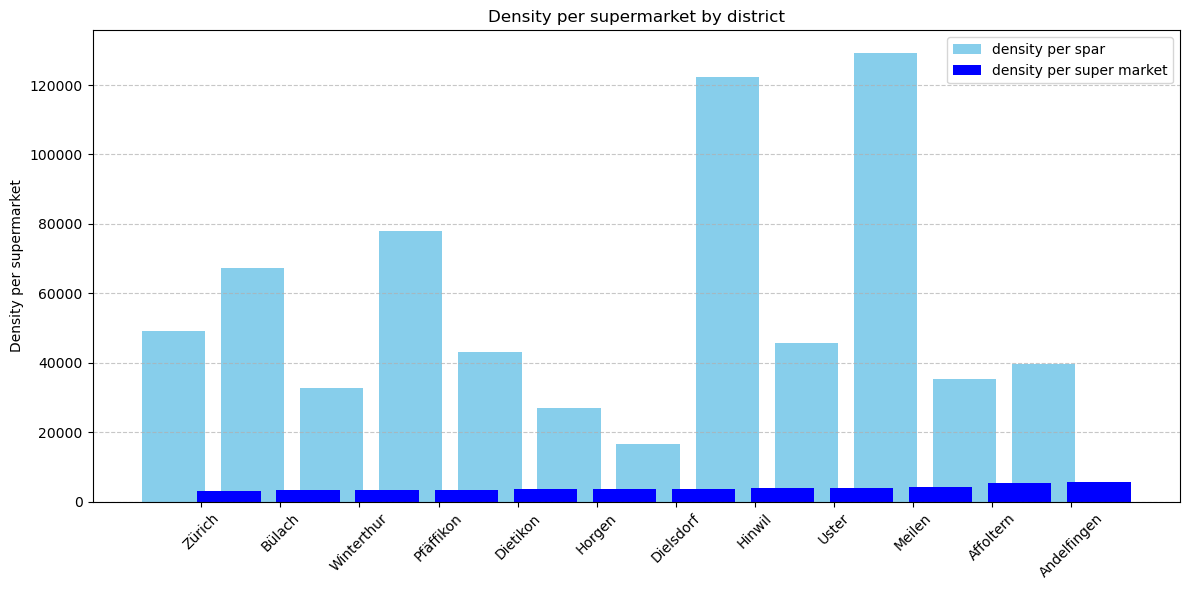

In [6]:
import numpy as np
# Sort by people_per_super and take top 10
plot_df = best_opportunities.sort_values('people_per_supermarket', ascending=True).head(12)


x = np.arange(len(plot_df['district']))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x-width, plot_df['people_per_spar'], color='skyblue', label = 'density per spar')
plt.bar(x+width, plot_df['people_per_supermarket'], color='blue', label = 'density per super market')

# Add labels
#for bar in bars:
    #height = bar.get_height()
    #plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', ha='center', va='bottom')

plt.title('Density per supermarket by district')
plt.ylabel('Density per supermarket')
plt.xticks(x, plot_df['district'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
opportunity_df

,district,pop_2023,pop_2050,growth_rate_2050,Area (Area km²),growth_abs,dencity_growth,total_supermarkets,spar_supermarkets,spar_coverage_rate,people_per_spar,people_per_supermarket,growth_rate
0,Zürich,432552.0,539635.752,24.756273,91.9,107083.752,1165.220370,181,11,0.060773,49057.795636,2981.412994,24.756273
1,Dietikon,97401.0,128861.770,32.300254,60.1,31460.770,523.473710,37,3,0.081081,42953.923333,3482.750541,32.300254
2,Uster,139677.0,182505.939,30.662843,120.5,42828.939,355.426880,47,4,0.085106,45626.484750,3883.105085,30.662843
3,Horgen,130994.0,161132.538,23.007571,127.9,30138.538,235.641423,46,6,0.130435,26855.423000,3502.881261,23.007571
4,Bülach,163636.0,201593.545,23.196329,185.3,37957.545,204.843740,63,3,0.047619,67197.848333,3199.897540,23.196329
5,Winterthur,179830.0,228342.388,26.976805,251.1,48512.388,193.199474,71,7,0.098592,32620.341143,3216.089972,26.976805
6,Meilen,108615.0,129315.788,19.058867,116.8,20700.788,177.232774,32,1,0.031250,129315.788000,4041.118375,19.058867
7,Dielsdorf,94931.0,115232.579,21.385616,152.6,20301.579,133.037870,32,7,0.218750,16461.797000,3601.018094,21.385616
8,Hinwil,100651.0,122351.769,21.560411,179.5,21700.769,120.895649,32,1,0.031250,122351.769000,3823.492781,21.560411
9,Affoltern,57558.0,70496.544,22.479141,113.0,12938.544,114.500389,13,2,0.153846,35248.272000,5422.811077,22.479141


# Score and Rank Districts
We combine multiple key factors into a single score that helps SPAR identify the most strategic districts for expansion.

| Factor               | Why it Matters                          | Scoring Direction |
| -------------------- | --------------------------------------- | ----------------- |
| `Pop_Forecast`       | Indicates future demand                 | Higher is better  |
| `density_growth`        | Measures how fast demand is growing     | Higher is better  |
| `spar_coverage_rate` | Shows how much SPAR is already present  | Lower is better   |
| `people_per_supermarket` | Indicates how competitive the market is | Lower is better   |


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Copy relevant columns (using updated column names)
scoring_df = opportunity_df[['district', 'pop_2050', 'dencity_growth', 'spar_coverage_rate', 'people_per_supermarket']].copy()

# Normalize values between 0 and 1
scaler = MinMaxScaler()
scoring_df[['pop_2050', 'dencity_growth']] = scaler.fit_transform(scoring_df[['pop_2050', 'dencity_growth']])
scoring_df[['spar_coverage_rate', 'people_per_supermarket']] = 1 - scaler.fit_transform(scoring_df[['spar_coverage_rate', 'people_per_supermarket']])

# Composite score (weights can be adjusted)
scoring_df['score'] = (
    scoring_df['pop_2050'] * 0.3 +
    scoring_df['dencity_growth'] * 0.3 +
    scoring_df['spar_coverage_rate'] * 0.2 +
    scoring_df['people_per_supermarket'] * 0.2
)

# Sort and show top 12
top_ranked = scoring_df.sort_values(by='score', ascending=False)

# Format the top 12 rows with readable numbers
top_ranked.head(12).style.format({
    'pop_2050': '{:,.0f}',
    'dencity_growth': '{:.2f}',
    'spar_coverage_rate': '{:.2%}',
    'people_per_supermarket': '{:,.1f}',
    'score': '{:.3f}'
})


,district,pop_2050,dencity_growth,spar_coverage_rate,people_per_supermarket,score
0,Zürich,1,1.00,84.25%,1.0,0.969
4,Bülach,0,0.15,91.27%,0.9,0.507
1,Dietikon,0,0.43,73.42%,0.8,0.492
5,Winterthur,0,0.14,64.08%,0.9,0.464
2,Uster,0,0.28,71.28%,0.7,0.444
6,Meilen,0,0.12,100.00%,0.6,0.411
8,Hinwil,0,0.07,100.00%,0.7,0.408
10,Pfäffikon,0,0.05,93.48%,0.8,0.393
3,Horgen,0,0.17,47.10%,0.8,0.380
7,Dielsdorf,0,0.08,0.00%,0.8,0.223


📊 ***This table shows:*** 

Top-ranked districts for SPAR expansion based on a combined score calculated from: 

1- Forecasted population (Pop_Forecast) — how big the future market is 

2- Growth rate (growth_rate) — how fast that market is growing 

3- SPAR coverage rate (spar_coverage_rate) — how saturated the district is with SPAR branches (lower is better) 

4- Total supermarkets (total_supermarkets) — how competitive the area is (lower is better)

In [9]:
import folium

# Mock lat/lon for demonstration — replace with real ones!
coordinates = {
    'Dietikon': [47.4, 8.4],
    'Bülach': [47.5, 8.5],
    'Uster': [47.3, 8.7],
    'Zürich': [47.37, 8.55],
    'Winterthur': [47.5, 8.7]
}

# Create map centered on Zurich
m = folium.Map(location=[47.4, 8.5], zoom_start=10)

# Get top 5 districts
top_5_districts = top_ranked.head(5)

# Add markers
for _, row in top_5_districts.iterrows():
    district = row['district']
    if district in coordinates:
        folium.Marker(
            location=coordinates[district],
            popup=f"{district}\nScore: {row['score']:.3f}",
            tooltip=district,
            icon=folium.Icon(color='green')
        ).add_to(m)

# Show the map
m
